## Harjoitus 6 Klusterointimenetelmät k-means, Mean-Shift ja DBSCAN

Lataa wholesale customers data.csv oheisen linkin kautta http://archive.ics.uci.edu/ml/datasets/
Wholesale+customers. Luo Notebookiisi datasets niminen kansio ja siirrä tiedosto wholesale customers data.csv sen sisään.

## Data preprocessing

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

In [3]:
data = pd.read_csv("./wholesale_customers_data.csv")

In [4]:
data.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [5]:
outliers = {}
for i in range(data.shape[1]):
    min_t = data[data.columns[i]].mean() - (3 * data[data.columns[i]].std())
    max_t = data[data.columns[i]].mean() + (3 * data[data.columns[i]].std())
    count = 0
    for j in data[data.columns[i]]:
        if j < min_t or j > max_t:
            count += 1
    outliers[data.columns[i]] = [count,data.shape[0]-count]
print(outliers)

{'Channel': [0, 440], 'Region': [0, 440], 'Fresh': [7, 433], 'Milk': [9, 431], 'Grocery': [7, 433], 'Frozen': [6, 434], 'Detergents_Paper': [10, 430], 'Delicassen': [4, 436]}


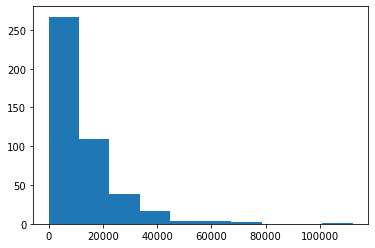

In [6]:
plt.hist(data["Fresh"])
plt.show()

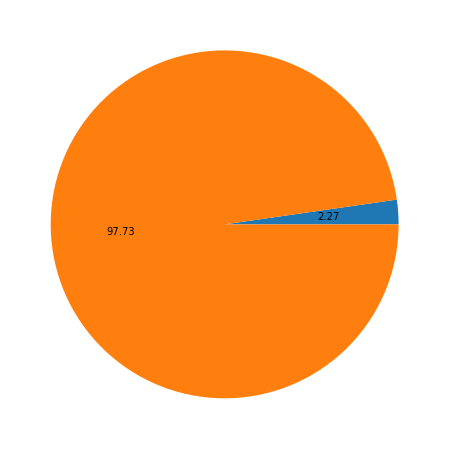

In [7]:
plt.figure(figsize=(8,8))
plt.pie(outliers["Detergents_Paper"],autopct="%.2f")
plt.show()

In [8]:
data_standardized = (data - data.mean())/data.std()
data_standardized.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.447005,0.589997,0.052873,0.522972,-0.041068,-0.588697,-0.043519,-0.066264
1,1.447005,0.589997,-0.390857,0.543839,0.170125,-0.269829,0.086309,0.089050
2,1.447005,0.589997,-0.446521,0.408073,-0.028125,-0.137379,0.133080,2.240742
3,-0.689512,0.589997,0.099998,-0.623310,-0.392530,0.686363,-0.498021,0.093305
4,1.447005,0.589997,0.839284,-0.052337,-0.079266,0.173661,-0.231654,1.297870


## k-means algorithm

In [9]:
from sklearn.cluster import KMeans

In [22]:
ideal_k = []
for i in range(1,30):
    est_kmeans = KMeans(n_clusters=i)
    est_kmeans.fit(data_standardized)
    
    ideal_k.append([i,est_kmeans.inertia_])

In [23]:
ideal_k = np.array(ideal_k)

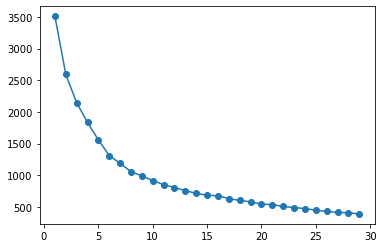

In [24]:
plt.plot(ideal_k[:,0],ideal_k[:,1], marker = 'o')
plt.show()

### Tehtävä 1: Valitse sopiva k:n arvo hyödyntäen yllä olevaa kuvaajaa

---
Koska kuvaaja laskee kokoajan, muttei tasoitu. Joten järkevin k:n arvo olisi suurimman pudotuksen jälkeen, eli 8-12.

In [129]:
est_kmeans = KMeans(n_clusters=10)
est_kmeans.fit(data_standardized)
pred_kmeans = est_kmeans.predict(data_standardized)

---
### Tehtävä 2: Toteuta alla olevaan tyhjään kohtaan Silhouette analysis kolmella eri k:n arvolla varmistuaksesi oikeasta k:n arvosta
Apuja saat täältä: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

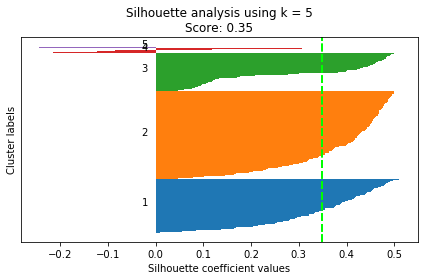

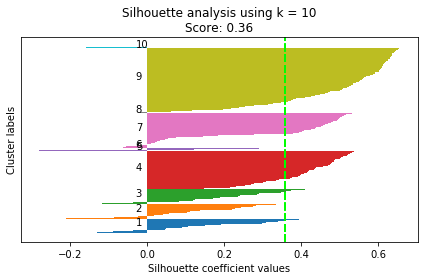

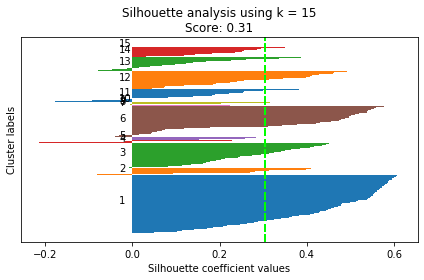

In [93]:
from sklearn.metrics import silhouette_samples,silhouette_score

# Mininum number of clusters for silhouette is 2
kluster_num = [5,10,15]
for g in kluster_num:
    # Run the kmeans algorithm
    km = KMeans(n_clusters = g)
    y_predict = km.fit_predict(data_standardized)
    centroids  = km.cluster_centers_

    # get silhouette
    silhouette_vals = silhouette_samples(data_standardized,y_predict)

    # silhouette plot
    y_ticks = []
    y_lower = y_upper = 0

    for i,cluster in enumerate(np.unique(y_predict)):

        cluster_silhouette_vals = silhouette_vals[y_predict ==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)

        # Horizontal bar plot
        plt.barh(range(y_lower,y_upper), cluster_silhouette_vals,height =1)

        plt.text(-0.03,(y_lower+y_upper)/2,str(i+1))
        y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score 
        avg_score = np.mean(silhouette_vals)
        plt.axvline(avg_score,linestyle ='--', 
                    linewidth =2,color = 'lime')

        plt.xlabel('Silhouette coefficient values')
        plt.ylabel('Cluster labels')
        # Remove ticks on y axis
        plt.yticks([])

        plt.tight_layout()
        plt.title(f"Silhouette analysis using k = {g}\nScore: {round(avg_score,2)}")
        
    plt.show()

#### Kuten näkyy, k:n arvolla 10 saadaan parhaat pisteet, sopii siihen 8-12 rajalle.
---

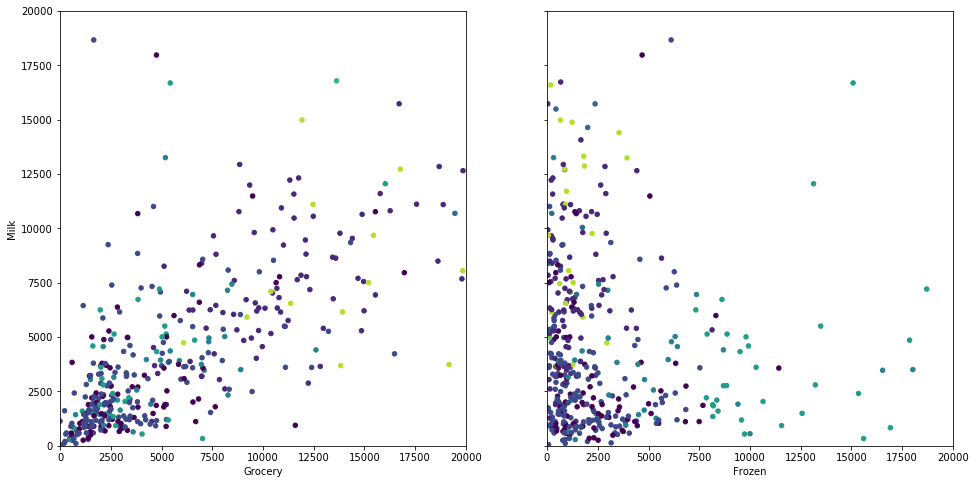

In [96]:
plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16,8))
plt.scatter(data.iloc[:,5], data.iloc[:,3], c=pred_kmeans, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Frozen')
plt.subplot(1, 2, 1)
plt.scatter(data.iloc[:,4], data.iloc[:,3], c=pred_kmeans, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Grocery')
plt.ylabel('Milk')
plt.show()

## Mean-Shift algorithm

In [97]:
from sklearn.cluster import MeanShift

In [98]:
est_meanshift = MeanShift(0.9)
est_meanshift.fit(data_standardized)
pred_meanshift = est_meanshift.predict(data_standardized)

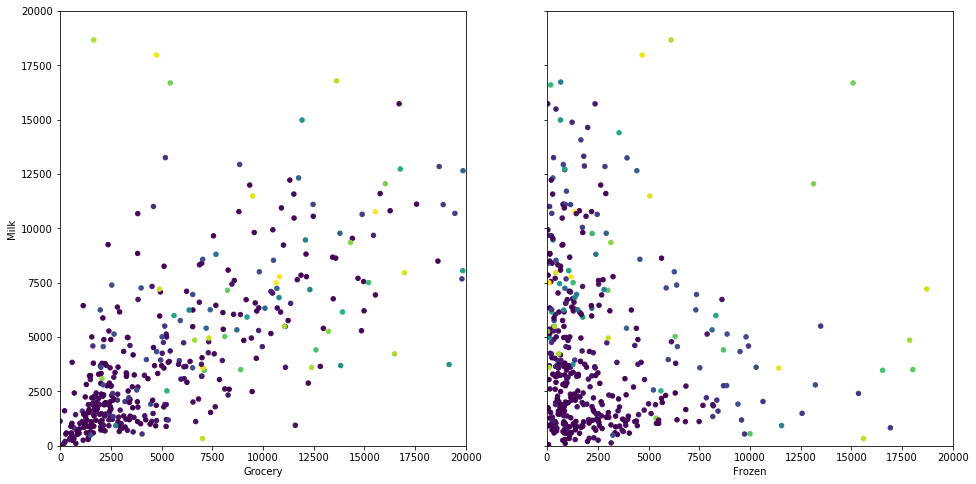

In [99]:
plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16,8))
plt.scatter(data.iloc[:,5], data.iloc[:,3], c=pred_meanshift, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Frozen')
plt.subplot(1, 2, 1)
plt.scatter(data.iloc[:,4], data.iloc[:,3], c=pred_meanshift, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Grocery')
plt.ylabel('Milk')
plt.show()

## DBSCAN algorithm

In [100]:
from sklearn.cluster import DBSCAN

In [101]:
est_dbscan = DBSCAN(eps=0.3)
pred_dbscan = est_dbscan.fit_predict(data_standardized)

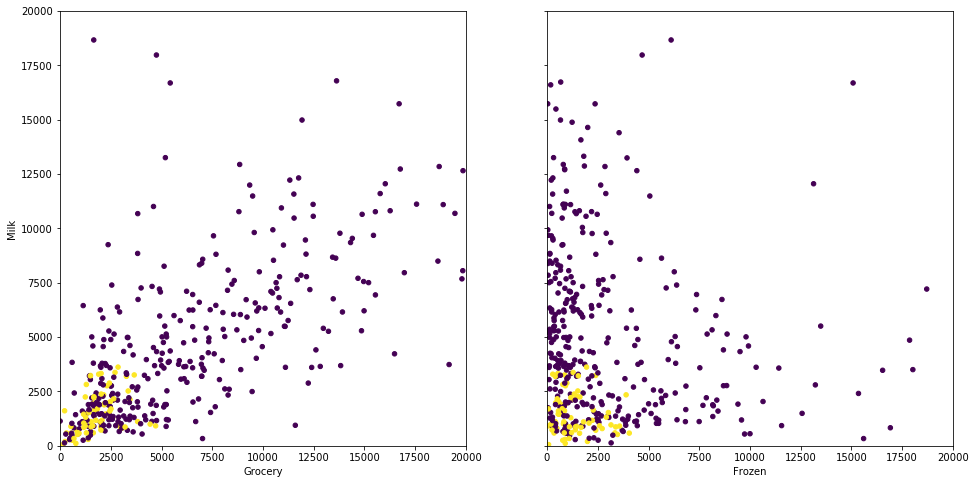

In [102]:
plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16,8))
plt.scatter(data.iloc[:,5], data.iloc[:,3], c=pred_dbscan, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Frozen')
plt.subplot(1, 2, 1)
plt.scatter(data.iloc[:,4], data.iloc[:,3], c=pred_dbscan, s=20)
plt.xlim([0, 20000])
plt.ylim([0,20000])
plt.xlabel('Grocery')
plt.ylabel('Milk')
plt.show()

## Clustering performance evaluation

In [103]:
from sklearn.metrics import silhouette_score

In [104]:
kmeans_score = silhouette_score(data_standardized, pred_kmeans, metric='euclidean')
meanshift_score = silhouette_score(data_standardized, pred_meanshift, metric='euclidean')
dbscan_score = silhouette_score(data_standardized, pred_dbscan, metric='euclidean')
print(kmeans_score, meanshift_score, dbscan_score)

0.36764282549516 0.1876897219797515 -0.06439381509463221


In [108]:
from sklearn.metrics import calinski_harabasz_score

In [109]:
kmeans_score = calinski_harabasz_score(data_standardized, pred_kmeans)
meanshift_score = calinski_harabasz_score(data_standardized, pred_meanshift)
dbscan_score = calinski_harabasz_score(data_standardized, pred_dbscan)
print(kmeans_score, meanshift_score, dbscan_score)

136.05952621593613 59.1712718293517 25.38229485397911


### Tehtävä 3: Varioi algoritmien Mean-Shift (bandwith) ja DBSCAN (eps) parametreja saadaksesi paremmat pisteet algoritmien suorituskyvyn evaluoinnista 

In [285]:
# Luodaan listat johon lisätään pisteet
kmeanslist = []
meanshiftlist = []
dbscan = []

kmeanslist_ch = []
meanshiftlist_ch = []
dbscan_ch = []

# Käytetty arvo (Iteraatio)
it = []

for i in range(2,31):

    est_meanshift = MeanShift(i/10)
    est_meanshift.fit(data_standardized)
    pred_meanshift = est_meanshift.predict(data_standardized)

    est_dbscan = DBSCAN(eps=i/10)
    pred_dbscan = est_dbscan.fit_predict(data_standardized)
    
    kmeans_score = silhouette_score(data_standardized, pred_kmeans, metric='euclidean')
    meanshift_score = silhouette_score(data_standardized, pred_meanshift, metric='euclidean')
    dbscan_score = silhouette_score(data_standardized, pred_dbscan, metric='euclidean')
    
    kmeanslist.append(kmeans_score)
    meanshiftlist.append(meanshift_score)
    dbscan.append(dbscan_score)
    
    kmeans_score = calinski_harabasz_score(data_standardized, pred_kmeans)
    meanshift_score = calinski_harabasz_score(data_standardized, pred_meanshift)
    dbscan_score = calinski_harabasz_score(data_standardized, pred_dbscan)
    
    kmeanslist_ch.append(kmeans_score)
    meanshiftlist_ch.append(meanshift_score)
    dbscan_ch.append(dbscan_score)
    
    it.append(i/10)

In [288]:
# Etsitään piste-listoista suurin ja otetaan sen indexi iteraatio-listalta
index1 = it[meanshiftlist.index(max(meanshiftlist))]
index2 = it[dbscan.index(max(dbscan))]

print("Best scores")
print("--"*50)
print(f"Silhouette score with value MeanShift: {index1} DBSCAN: {index2}")
print("kmeans: %f meanshift: %f dbscan: %f" % (max(kmeanslist), max(meanshiftlist), max(dbscan)))

print("\nCalinski Harabasz score")
print("kmeans: %f meanshift: %f dbscan: %f" % (max(kmeanslist_ch), max(meanshiftlist_ch), max(dbscan_ch)))

Best scores
----------------------------------------------------------------------------------------------------
Silhouette score with value MeanShift: 3.0 DBSCAN: 2.7
kmeans: 0.336138 meanshift: 0.464489 dbscan: 0.686648

Calinski Harabasz score
kmeans: 133.230440 meanshift: 447.803694 dbscan: 127.755932


- MeanShift = 3.0
- DBSCAN = 2.7

#### Näillä arvoilla tuli parhaimmat tulokset
---

### Bonustehtävä: Pyri löytämään visualisointimenetelmä klusteroidulle datalle, josta käy selkeämmin ilmi klusterit, joihin kukin algoritmi on datan klusteroinut
Luo kullekin klusterointi-algoritmille oma kuvaajansa, josta käy ilmi eri klusterit

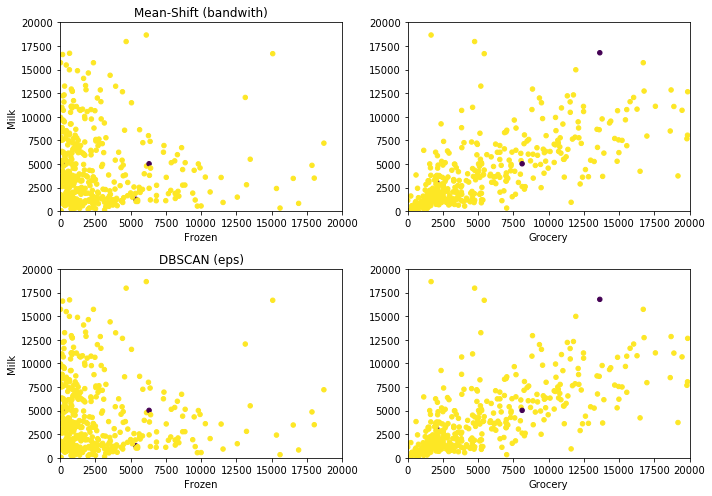

In [290]:
fig, axes= plt.subplots(nrows=2, ncols=2,figsize=(10,7))

est_meanshift = MeanShift(index1)
est_meanshift.fit(data_standardized)
pred_meanshift = est_meanshift.predict(data_standardized)

axes[0,0].set_title("Mean-Shift (bandwith)")
axes[0,0].scatter(data.iloc[:,5], data.iloc[:,3], c=pred_dbscan, s=20)
axes[0,1].scatter(data.iloc[:,4], data.iloc[:,3], c=pred_dbscan, s=20)
axes[0,0].set_xlim([0, 20000]),axes[0,0].set_ylim([0,20000])
axes[0,1].set_xlim([0, 20000]),axes[0,1].set_ylim([0,20000])
axes[0,0].set_xlabel('Frozen')
axes[0,0].set_ylabel("Milk")
axes[0,1].set_xlabel("Grocery")


est_dbscan = DBSCAN(eps=index2)
pred_dbscan = est_dbscan.fit_predict(data_standardized)

axes[1,0].set_title("DBSCAN (eps)")
axes[1,0].scatter(data.iloc[:,5], data.iloc[:,3], c=pred_dbscan, s=20)
axes[1,1].scatter(data.iloc[:,4], data.iloc[:,3], c=pred_dbscan, s=20)
axes[1,0].set_xlim([0, 20000]),axes[1,0].set_ylim([0,20000])
axes[1,1].set_xlim([0, 20000]),axes[1,1].set_ylim([0,20000])
axes[1,0].set_xlabel('Frozen')
axes[1,0].set_ylabel("Milk")
axes[1,1].set_xlabel("Grocery")
plt.tight_layout()

plt.show()

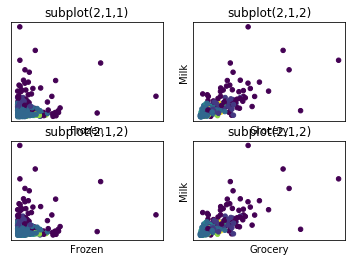

In [170]:
plt.figsize=(10,4)

est_meanshift = MeanShift(0.3)
est_meanshift.fit(data_standardized)
pred_meanshift = est_meanshift.predict(data_standardized)

plt.subplot(2,2,1)
plt.xticks([])
plt.yticks([])
plt.title('subplot(2,1,1)')
plt.scatter(data.iloc[:,5], data.iloc[:,3], c=pred_dbscan, s=20)
plt.xlabel('Frozen')
#plt.plot(t,s)

plt.subplot(2,2,2)
plt.xticks([])
plt.yticks([])
plt.title('subplot(2,1,2)')
plt.scatter(data.iloc[:,4], data.iloc[:,3], c=pred_dbscan, s=20)
plt.xlabel('Grocery')
plt.ylabel('Milk')
#plt.plot(t,s,'r-')

est_dbscan = DBSCAN(eps=1)
pred_dbscan = est_dbscan.fit_predict(data_standardized)
plt.subplot(2,2,3)
plt.xticks([])
plt.yticks([])
plt.title('subplot(2,1,2)')
plt.scatter(data.iloc[:,5], data.iloc[:,3], c=pred_dbscan, s=20)
plt.xlabel('Frozen')

plt.subplot(2,2,4)
plt.xticks([])
plt.yticks([])
plt.title('subplot(2,1,2)')
plt.scatter(data.iloc[:,4], data.iloc[:,3], c=pred_dbscan, s=20)
plt.xlabel('Grocery')
plt.ylabel('Milk')

plt.show()